In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer,AutoProcessor, BitsAndBytesConfig, get_scheduler,Gemma3ForConditionalGeneration
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch
from IPython.display import  clear_output
import time
import gc
from torch.utils.data import Dataset, DataLoader
# import here opencv



# device_name = 'cuda:0' if cuda.is_available() else 'cpu'
# device = torch.device(device_name)

DEFAULT_MODEL = "google/gemma-3-4b-it"

bnb_config = BitsAndBytesConfig(
                                load_in_4bit=True,
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_quant_type='nf4',
                                bnb_4bit_compute_dtype=torch.bfloat16,
                                bnb_4bit_quant_storage=torch.bfloat16,
                                )


model = Gemma3ForConditionalGeneration.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    attn_implementation='eager',
    device_map={'':torch.cuda.current_device()},
    torch_dtype=torch.bfloat16
    
)

print(model.get_memory_footprint()/(1024*1024)) 

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL)

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()


2025-04-29 09:36:25.939805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745919385.949483 2141419 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745919385.952426 2141419 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 09:36:25.963251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

3023.7419147491455


In [8]:
model.config.model_type

'gemma3'

# Load a Multi Lingual Dataset

In [2]:
from datasets import load_dataset

# Load the dataset
# dataset = load_dataset("OdiaGenAI/hardcode_odia_qa_105")
dataset = load_dataset('OdiaGenAI/odia_domain_context_train_v1')

In [3]:
dataset['train'][50]

{'instruction': '‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞ ‡¨â‡¨¶‡≠ü‡¨ó‡¨ø‡¨∞‡¨ø ‡¨è‡¨¨‡¨Ç ‡¨ñ‡¨£‡≠ç‡¨°‡¨ó‡¨ø‡¨∞‡¨ø ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ‡¨∞ ‡¨á‡¨§‡¨ø‡¨π‡¨æ‡¨∏ ‡¨ï‚Äô‡¨£?',
 'input': '',
 'output': '‡¨â‡¨¶‡≠ü‡¨ó‡¨ø‡¨∞‡¨ø ‡¨è‡¨¨‡¨Ç ‡¨ñ‡¨£‡≠ç‡¨°‡¨ó‡¨ø‡¨∞‡¨ø ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ ‡¨≠‡¨æ‡¨∞‡¨§‡¨∞ ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ ‡¨∞‡¨æ‡¨ú‡≠ç‡≠ü‡¨∞‡≠á ‡¨Ö‡¨¨‡¨∏‡≠ç‡¨•‡¨ø‡¨§ ‡¨™‡≠ç‡¨∞‡¨æ‡¨ö‡≠Ä‡¨® ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ ‡¨™‡¨∞‡¨ø‡¨∏‡¨∞‡¨∞ ‡¨è‡¨ï ‡¨∏‡¨Æ‡≠Ç‡¨π‡•§ ‡¨è‡¨π‡¨ø ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ ‡¨ó‡≠Å‡¨°‡¨ø‡¨ï ‡¨ñ‡≠ç‡¨∞‡≠Ä‡¨∑‡≠ç‡¨ü‡¨™‡≠Ç‡¨∞‡≠ç‡¨¨ ‡¨¶‡≠ç‡≠±‡¨ø‡¨§‡≠Ä‡≠ü ‡¨∂‡¨§‡¨æ‡¨¨‡≠ç‡¨¶‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨™‡≠ç‡¨∞‡¨•‡¨Æ ‡¨∂‡¨§‡¨æ‡¨¨‡≠ç‡¨¶‡≠Ä ‡¨Æ‡¨ß‡≠ç‡≠ü‡¨∞‡≠á ‡¨ú‡≠à‡¨® ‡¨∏‡¨®‡≠ç‡¨®‡≠ç‡≠ü‡¨æ‡¨∏‡≠Ä‡¨Æ‡¨æ‡¨®‡¨ô‡≠ç‡¨ï ‡¨¶‡≠ç‡≠±‡¨æ‡¨∞‡¨æ ‡¨¨‡¨æ‡¨≤‡≠Å‡¨ï‡¨æ ‡¨™‡¨•‡¨∞‡¨∞‡≠á ‡¨ñ‡≠ã‡¨¶‡¨ø‡¨§ ‡¨π‡≠ã‡¨á‡¨•‡¨ø‡¨¨‡¨æ ‡¨ú‡¨£‡¨æ‡¨Ø‡¨æ‡¨è‡•§\n‡¨â‡¨¶‡≠ü‡¨ó‡¨ø‡¨∞‡¨ø ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ ‡¨ó‡≠Å‡¨°‡¨ø‡¨ï ‡¨¨‡≠É‡¨π‡¨§ ‡¨è‡¨¨‡¨Ç ‡¨Ö‡¨ß‡¨ø‡¨ï ‡¨ú‡¨ü‡¨ø‡¨≥ ‡¨π‡≠ã‡¨á‡¨•‡¨ø‡¨¨‡¨æ‡¨¨‡≠á‡¨≥‡≠á ‡¨ñ‡¨£‡≠ç‡¨°‡¨ó‡¨ø‡¨∞‡¨ø ‡¨ó‡≠Å‡¨Æ‡≠ç‡¨´‡¨æ ‡¨ó‡≠Å‡¨°‡¨ø‡¨ï ‡¨õ‡≠ã‡¨ü ‡¨è‡¨¨‡¨Ç ‡¨

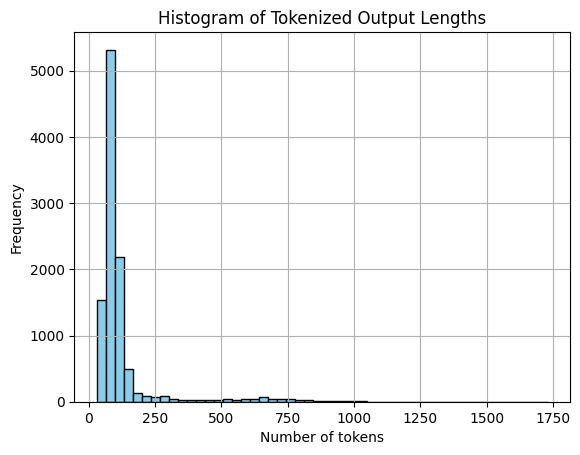

In [4]:
import matplotlib.pyplot as plt
lengths = [len(tokenizer(example['instruction']+ example['output'])['input_ids']) for example in dataset['train']]

# Plot the histogram
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Tokenized Output Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Automatic Training using TRL

In [ ]:
def create_conversation(sample):
  return {
    "messages": [
      # {"role": "system", "content": system_message},
      {"role": "user", "content": sample['instruction']},
      {"role": "assistant", "content": sample["output"]}
    ]
  }


# Convert dataset to OAI messages
dataset = dataset.map(create_conversation, remove_columns=['output','instruction','input'],batched=False)
# split dataset into 10,000 training samples and 2,500 test samples
# dataset = dataset.train_test_split(test_size=2500/12500)

# # Print formatted user prompt
# print(dataset["train"][345]["messages"][1]["content"])

Map:   0%|          | 0/10502 [00:00<?, ? examples/s]

In [ ]:
tokenizer.apply_chat_template(dataset['train'][0]['messages'],tokenize=False)

'<bos><start_of_turn>user\n‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞ ‡¨Ö‡¨∞‡≠ç‡¨•‡¨®‡≠Ä‡¨§‡¨ø ‡¨â‡¨™‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨∞ ‡¨ï‡¨ø‡¨≠‡¨≥‡¨ø ‡¨™‡≠ç‡¨∞‡¨≠‡¨æ‡¨¨ ‡¨™‡¨°‡¨º‡¨ø‡¨õ‡¨ø?<end_of_turn>\n<start_of_turn>model\n‡¨¨‡¨ø‡¨ó‡¨§ ‡¨ï‡¨ø‡¨õ‡¨ø ‡¨¨‡¨∞‡≠ç‡¨∑ ‡¨Æ‡¨ß‡≠ç‡≠ü‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨∂‡¨ø‡¨≥‡≠ç‡¨™ ‡¨¶‡≠ç‡≠±‡¨æ‡¨∞‡¨æ ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞ ‡¨Ö‡¨∞‡≠ç‡¨•‡¨®‡≠Ä‡¨§‡¨ø ‡¨¨‡≠ç‡≠ü‡¨æ‡¨™‡¨ï ‡¨≠‡¨æ‡¨¨‡≠á ‡¨™‡≠ç‡¨∞‡¨≠‡¨æ‡¨¨‡¨ø‡¨§ ‡¨π‡≠ã‡¨á‡¨õ‡¨ø‡•§ ‡¨∞‡¨æ‡¨ú‡≠ç‡≠ü‡¨∞‡≠á ‡¨™‡≠ç‡¨∞‡¨æ‡¨ï‡≠É‡¨§‡¨ø‡¨ï ‡¨∏‡≠å‡¨®‡≠ç‡¨¶‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨è‡¨¨‡¨Ç ‡¨∏‡¨æ‡¨Ç‡¨∏‡≠ç‡¨ï‡≠É‡¨§‡¨ø‡¨ï ‡¨ê‡¨§‡¨ø‡¨π‡≠ç‡≠ü ‡¨∏‡≠ç‡¨•‡¨æ‡¨® ‡¨∞‡¨π‡¨ø‡¨õ‡¨ø, ‡¨Ø‡¨æ‡¨π‡¨æ ‡¨¶‡≠á‡¨∂ ‡¨è‡¨¨‡¨Ç ‡¨¶‡≠á‡¨∂ ‡¨¨‡¨æ‡¨π‡¨æ‡¨∞‡¨∞ ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨ï‡¨ô‡≠ç‡¨ï ‡¨™‡¨æ‡¨á‡¨Å ‡¨Ü‡¨ï‡¨∞‡≠ç‡¨∑‡¨£‡≠Ä‡≠ü ‡¨π‡≠ã‡¨á‡¨™‡¨æ‡¨∞‡¨ø‡¨õ‡¨ø‡•§\n‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞‡¨∞‡≠á ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨ï‡¨∞‡≠Å‡¨•‡¨ø‡¨¨‡¨æ ‡¨≤‡≠ã‡¨ï‡¨Æ‡¨æ‡¨®‡¨ô‡≠ç‡¨ï ‡¨™‡¨æ‡¨á‡¨Å ‡¨®‡¨ø‡¨Ø‡≠Å‡¨ï‡≠ç‡¨§‡¨ø ‡¨∏‡≠Å‡¨Ø‡≠ã‡¨ó ‡¨è‡¨¨‡¨Ç ‡¨Ü‡≠ü ‡¨¨‡≠É‡¨¶‡≠ç‡¨ß‡¨

In [7]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=["lm_head", "embed_tokens"] # make sure to save the lm_head and embed_tokens as you train the special tokens
)

In [9]:
from trl import SFTConfig
torch_dtype = torch.bfloat16
args = SFTConfig(
    output_dir="gemma-text-to-sql",         # directory to save and repository id
    max_seq_length=512,                     # max sequence length for model and packing of the dataset
    packing=True,                           # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=1,          # batch size per device during training
    gradient_accumulation_steps=4,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=10,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,   # use bfloat16 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    dataset_kwargs={
        "add_special_tokens": False, # We template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    }
)

In [10]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    peft_config=peft_config,
    processing_class=tokenizer
)

comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [11]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-pack

HfHubHTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/models/Mohan-diffuser/gemma-text-to-sql/preupload/main (Request ID: Root=1-680b835b-00f55311711422712ea6f078;3de44368-d484-46cb-9f99-ff2f9c551958)

Invalid credentials in Authorization header

In [12]:
trainer.save_model()

comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key


events.out.tfevents.1745581212.rack-gpu-02.1626713.0:   0%|          | 0.00/63.8k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
# free the memory again
del model
del trainer
torch.cuda.empty_cache()

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer,AutoProcessor, BitsAndBytesConfig, get_scheduler,Gemma3ForConditionalGeneration
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch

model_id= "google/gemma-3-4b-it"
# Load Model base model
bnb_config = BitsAndBytesConfig(
                                load_in_4bit=True,
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_quant_type='nf4',
                                bnb_4bit_compute_dtype=torch.bfloat16,
                                bnb_4bit_quant_storage=torch.bfloat16,
                                )


model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    attn_implementation='eager',
    device_map={'':torch.cuda.current_device()},
    torch_dtype=torch.bfloat16
    
).eval()

# Merge LoRA and base model and save
peft_model = PeftModel.from_pretrained(model, 'gemma-text-to-sql').to('cuda')
tokenizer = AutoTokenizer.from_pretrained('gemma-text-to-sql')

2025-04-25 13:05:25.680784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745586325.690528 1636331 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745586325.693544 1636331 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 13:05:25.704657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def generate_eval(model,idx=5,disable_lora=False):
    
    model.config.use_cache = True
    sample=dataset['train'][idx]
    question=sample['instruction']
    answer = sample['output']
    chat_template = f'''<bos><start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n'''
    inputs = tokenizer(chat_template , return_tensors="pt").to('cuda').to(torch.float16)
    # print(prompt)

    model.eval()


    if disable_lora:
        with model.disable_adapter():
            output = model.generate(
                **inputs,
                do_sample=True,
                max_new_tokens=256,
                repetition_penalty=1.3,
                temperature=0.7,         # Optional: smooth randomness
                top_k=50,                # Optional: top-k sampling
                top_p=0.9                # Optional: nucleus sampling
            )
    else:
        output = model.generate(
        **inputs,
        do_sample=False,
        max_new_tokens=256,
        repetition_penalty=1.3,
        temperature=0.2,         # Optional: smooth randomness
        top_k=50,                # Optional: top-k sampling
        top_p=0.9                # Optional: nucleus sampling
        )

    processed_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    model.train()

    return processed_text,answer

In [10]:
pred,true=generate_eval(peft_model,idx=56,disable_lora=False)

Attempting to cast a BatchEncoding to type torch.float16. This is not supported.


/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [11]:
print(pred)
print('*'*30)
print(true)

<bos><bos><start_of_turn>user
‡¨™‡≠ç‡¨∞‡¨§‡¨ø‡¨¨‡¨∞‡≠ç‡¨∑ ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ ‡¨™‡≠Å‡¨∞‡¨∏‡≠ç‡¨ï‡¨æ‡¨∞ ‡¨¨‡¨ø‡¨ú‡≠á‡¨§‡¨æ‡¨Æ‡¨æ‡¨®‡¨ô‡≠ç‡¨ï‡≠Å ‡¨ï‡¨ø‡¨™‡¨∞‡¨ø ‡¨ö‡≠ü‡¨® ‡¨ï‡¨∞‡¨æ‡¨Ø‡¨æ‡¨á‡¨•‡¨æ‡¨è?<end_of_turn>
<start_of_turn>model
‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‡¨™‡≠ç‡¨∞‡¨§‡≠ç‡≠ü‡¨ï‡≠ç‡¨∑ ‡¨≠‡¨æ‡¨¨‡¨∞‡≠á ‡¨è‡¨π‡¨ø ‡¨â‡¨§‡≠ç‡¨∏‡¨¨ ‡¨Ü‡≠ü‡≠ã‡¨ú‡¨® ‡¨ï‡¨∞‡¨ø‡¨•‡¨æ‡¨®‡≠ç‡¨§‡¨ø‡•§ ‡¨Ö‡¨®‡≠ç‡≠ü ‡¨∞‡¨æ‡¨ú‡≠ç‡≠ü‡¨ó‡≠Å‡¨°‡¨ø‡¨ï‡¨†‡¨æ‡¨∞‡≠Å ‡¨Ø‡≠å‡¨® ‡¨®‡¨ø‡¨Æ‡≠ç‡¨®‡¨∏‡≠ç‡¨§‡¨∞‡≠Ä‡≠ü ‡¨ó‡¨§‡¨ø‡¨¨‡¨ø‡¨ß‡¨ø‡¨ï‡≠Å ‡¨¶‡≠Ç‡¨∞ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨™‡¨æ‡¨á‡¨Å ‡¨Æ‡¨ß‡≠ç‡≠ü ‡¨ú‡¨£‡≠á ‡¨¨‡≠ç‡≠ü‡¨ï‡≠ç‡¨§‡¨ø‡¨ï‡≠Å ‡¨ö‡≠ü‡¨® ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨™‡¨æ‡¨á‡¨Å ‡¨è‡¨π‡¨æ ‡¨è‡¨ï ‡¨™‡≠ç‡¨∞‡¨≠‡¨æ‡¨¨‡¨∂‡¨æ‡¨≥‡≠Ä ‡¨™‡≠ç‡¨∞‡¨¶‡¨∞‡≠ç‡¨∑‡≠ç‡¨ü‡¨®‡≠Ä ‡¨π‡≠ã‡¨á‡¨õ‡¨ø, ‡¨ï‡¨ø‡¨®‡≠ç‡¨§‡≠Å ‡¨è‡¨π‡¨æ‡¨∞ ‡¨∂‡≠à‡¨≥‡≠Ä‡¨∞‡≠á ‡¨™‡¨∞‡¨ø‡¨¨‡¨∞‡≠ç‡¨§‡≠ç‡¨§‡¨® ‡¨Ü‡¨∏‡¨ø‡¨õ‡¨ø‡•§
‡¨Ö‡¨®‡≠ç‡≠ü ‡¨è‡¨ï ‡¨ñ‡¨¨‡¨∞‡¨™‡¨§‡≠ç‡¨∞‡¨∞‡≠á ‡¨ò‡¨ü‡¨ø‡¨•‡¨ø‡¨¨‡¨æ ‡¨Ö‡¨®‡≠Å‡¨Ø‡¨æ‡≠ü‡≠Ä, ‡¨™‡≠ç‡¨∞‡¨§‡¨ø‡¨¨‡¨∞‡≠ç‡¨∑ ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‚Äò‡

# Manual Pytorch Loop

In [9]:
messages = [
    [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a helpful assistant"},]
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": "what is capital of france?"},]
        },
    ],
]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device).to(torch.bfloat16)


with torch.inference_mode():
    outputs = model.generate(**inputs, max_new_tokens=64)

# outputs = tokenizer.batch_decode(outputs)

Attempting to cast a BatchEncoding to type torch.bfloat16. This is not supported.


In [10]:
outputs = tokenizer.batch_decode(outputs, skip_special_tokens=False)
print(outputs)

['<bos><start_of_turn>user\nYou are a helpful assistant\n\nwhat is capital of france?<end_of_turn>\n<start_of_turn>model\nThe capital of France is **Paris**. üòä \n\nIt‚Äôs a beautiful and iconic city! \n\nIs there anything else you‚Äôd like to know about France or Paris?<end_of_turn>']


## Create the Dataset Object for Pytorch-Dataset

In [11]:
# Custom PyTorch Dataset
from os import truncate


class LlamaDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        question=sample['instruction']
        answer = sample['output']
        prompt = f'''<bos><start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n'''
        full_text = prompt+f'''{answer}<end_of_turn>'''

        tokenized = tokenizer(full_text,add_special_tokens=False,truncation=True,max_length=250)

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Tokenize just the prompt to get the split point
        prompt_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]
        answer_start = len(prompt_ids)

        # Mask everything before answer_start
        labels = [-100] * answer_start + input_ids[answer_start:]
        # Mask out padding as well
        labels = [
            label if token != tokenizer.pad_token_id else -100
            for label, token in zip(labels, input_ids)
        ]
    
        return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attention_mask),
        "labels": torch.tensor(labels)
    }
        

In [12]:
from torch.nn.utils.rnn import pad_sequence
def llama_collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad sequences to the max length in the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "labels": labels_padded
    }

In [ ]:
from torch.utils.data import random_split, DataLoader

# Assume dataset['train'] is the full dataset you want to split
full_dataset = dataset['train']


# Split the dataset
train_data, test_data = random_split(full_dataset, [0.95, 0.05])

# Wrap in your custom Dataset class
train_dataset = LlamaDataset(train_data)
test_dataset = LlamaDataset(test_data)

# DataLoaders with custom collate_fn
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=llama_collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=llama_collate_fn
)

In [27]:
for batch in train_dataloader:
    break

In [ ]:
batch['input_ids'].shape

torch.Size([2, 98])

: 

In [12]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

vision_tower.vision_model.embeddings.patch_embedding.weight  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.embeddings.patch_embedding.bias  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.embeddings.position_embedding.weight  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.encoder.layers.0.layer_norm1.weight  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.encoder.layers.0.layer_norm1.bias  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.weight  dtype: torch.bfloat16  requirs grad:  False
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias  dtype: torch.bfloat16  requirs grad:  False
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.weight  dtype: torch.bfloat16  requirs grad:  False
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.bias  dtype: torch.bfloat16  requirs grad:  False
vision_tower.vision_model.encoder

# Purpose of `prepare_model_for_kbit_training`

When you load a model in 4-bit or 8-bit precision using bitsandbytes, some layers (like LayerNorm) still remain in full precision (float32), and certain operations (like weight updates) can be unstable or incompatible if done blindly on quantized weights.

- Casts `LayerNorm` layers to `float32`
- Sets `requires_grad=False` for all model parameters
- Wraps the output layer (like `lm_head`) in `float32`

In [13]:
# model = prepare_model_for_kbit_training(model)

In [13]:
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 42,734,080 || all params: 4,342,813,552 || trainable%: 0.9840


In [14]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.vision_tower.vision_model.embeddings.patch_embedding.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.embeddings.patch_embedding.bias  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.embeddings.position_embedding.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.base_layer.bias  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: to

In [16]:
model.config.model_type

'gemma3'

In [16]:
# question = '''‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨™‡¨æ‡¨á‡¨Å ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞ ‡¨ï‡¨ø‡¨™‡¨∞‡¨ø ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨Æ‡¨ø‡¨∂‡¨ø ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á?'''
# answer = '''‡¨Ø‡≠á‡¨ï‡≠å‡¨£‡¨∏‡¨ø ‡¨∞‡¨æ‡¨ú‡≠ç‡≠ü‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨™‡¨æ‡¨á‡¨Å ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞‡¨∞ ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨§ ‡¨™‡≠ç‡¨∞‡≠ü‡¨æ‡¨∏‡¨∞ ‡¨Ü‡¨¨‡¨∂‡≠ç‡≠ü‡¨ï‡¨§‡¨æ ‡¨∞‡¨π‡¨ø‡¨õ‡¨ø‡•§ ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞ ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞ ‡¨∞‡¨æ‡¨ú‡≠ç‡≠ü‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨è‡¨ï ‡¨¨‡¨ø‡¨∏‡≠ç‡¨§‡≠É‡¨§ ‡¨∞‡¨£‡¨®‡≠Ä‡¨§‡¨ø ‡¨¨‡¨ø‡¨ï‡¨∂‡¨ø‡¨§ ‡¨è‡¨¨‡¨Ç ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨§ ‡¨≠‡¨æ‡¨¨‡≠á ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á‡•§
# ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞ ‡¨∏‡¨π‡¨ø‡¨§ ‡¨Æ‡¨ø‡¨∂‡¨ø ‡¨ï‡¨æ‡¨Æ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ‡¨∞ ‡¨ó‡≠ã‡¨ü‡¨ø‡¨è ‡¨â‡¨™‡¨æ‡≠ü ‡¨π‡≠á‡¨≤‡¨æ ‡¨ò‡¨∞‡≠ã‡¨á ‡¨®‡¨ø‡¨¨‡≠á‡¨∂ ‡¨™‡¨æ‡¨á‡¨Å ‡¨Ö‡¨®‡≠Å‡¨ï‡≠Ç‡¨≥ ‡¨¨‡¨æ‡¨§‡¨æ‡¨¨‡¨∞‡¨£ ‡¨∏‡≠É‡¨∑‡≠ç‡¨ü‡¨ø ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ, ‡¨è‡¨•‡¨ø‡¨∞‡≠á ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞‡¨∞ ‡¨≠‡¨æ‡¨ó‡¨ø‡¨¶‡¨æ‡¨∞‡≠Ä‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨™‡¨æ‡¨á‡¨Å ‡¨ü‡¨ø‡¨ï‡¨∏ ‡¨è‡¨¨‡¨Ç ‡¨®‡¨ø‡≠ü‡¨æ‡¨Æ‡¨ï ‡¨™‡≠ç‡¨∞‡¨§‡¨ø‡¨¨‡¨®‡≠ç‡¨ß‡¨ï‡¨ï‡≠Å ‡¨π‡≠ç‡¨∞‡¨æ‡¨∏ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ, ‡¨è‡¨π‡¨æ ‡¨¨‡≠ç‡≠ü‡¨§‡≠Ä‡¨§ ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‡¨ü‡¨ø‡¨ï‡¨∏ ‡¨∞‡¨ø‡¨π‡¨æ‡¨§‡¨ø, ‡¨∏‡¨¨‡¨∏‡¨ø‡¨°‡¨ø ‡¨è‡¨¨‡¨Ç ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨¨‡¨ø‡¨ï‡¨æ‡¨∂ ‡¨™‡≠ç‡¨∞‡¨ï‡¨≥‡≠ç‡¨™ ‡¨™‡¨æ‡¨á‡¨Å ‡¨ú‡¨Æ‡¨ø ‡¨Ü‡¨¶‡¨ø ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨Æ‡¨ß‡≠ç‡≠ü ‡¨™‡≠ç‡¨∞‡¨¶‡¨æ‡¨® ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á‡•§
# ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞ ‡¨∏‡¨π ‡¨Æ‡¨ø‡¨∂‡¨ø ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞ ‡¨∏‡¨π ‡¨Æ‡¨ø‡¨∂‡¨ø ‡¨®‡≠Ç‡¨§‡¨® ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨â‡¨§‡≠ç‡¨™‡¨æ‡¨¶ ‡¨™‡≠ç‡¨∞‡¨∏‡≠ç‡¨§‡≠Å‡¨§ ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á ‡¨Ø‡¨æ‡¨π‡¨æ ‡¨â‡¨≠‡≠ü ‡¨ò‡¨∞‡≠ã‡¨á ‡¨è‡¨¨‡¨Ç ‡¨Ö‡¨®‡≠ç‡¨§‡¨∞‡≠ç‡¨ú‡¨æ‡¨§‡≠Ä‡≠ü ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨ï‡¨ô‡≠ç‡¨ï ‡¨Ü‡¨¨‡¨∂‡≠ç‡≠ü‡¨ï‡¨§‡¨æ ‡¨™‡≠Ç‡¨∞‡¨£ ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡•§
# ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‡¨Æ‡¨ß‡≠ç‡≠ü ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞‡¨∞ ‡¨≠‡¨æ‡¨ó‡¨ø‡¨¶‡¨æ‡¨∞‡≠Ä‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨™‡¨æ‡¨á‡¨Å ‡¨™‡≠ç‡¨∞‡¨Ø‡≠Å‡¨ï‡≠ç‡¨§‡¨ø‡¨∞ ‡¨â‡¨™‡¨Ø‡≠ã‡¨ó ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á‡•§ ‡¨â‡¨¶‡¨æ‡¨π‡¨∞‡¨£ ‡¨∏‡≠ç‡≠±‡¨∞‡≠Ç‡¨™, ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞ ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨∏‡≠ç‡¨•‡¨≥‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨è‡¨¨‡¨Ç ‡¨∏‡¨Æ‡≠ç‡¨≠‡¨æ‡¨¨‡≠ç‡≠ü ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨ï‡¨Æ‡¨æ‡¨®‡¨ô‡≠ç‡¨ï ‡¨∏‡¨π‡¨ø‡¨§ ‡¨Ø‡≠ã‡¨°‡¨º‡¨ø‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨∏‡≠ã‡¨∏‡¨ø‡¨Ü‡¨≤ ‡¨Æ‡¨ø‡¨°‡¨ø‡¨Ü ‡¨™‡≠ç‡¨≤‡¨æ‡¨ü‡¨´‡¨∞‡≠ç‡¨Æ‡¨∞ ‡¨â‡¨™‡¨Ø‡≠ã‡¨ó ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á‡•§ ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨Ü‡¨ï‡¨∞‡≠ç‡¨∑‡¨£ ‡¨è‡¨¨‡¨Ç ‡¨Ö‡¨®‡≠Å‡¨≠‡¨¨ ‡¨™‡≠ç‡¨∞‡¨¶‡¨∞‡≠ç‡¨∂‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨è‡¨ï ‡¨Ö‡¨®‡¨≤‡¨æ‡¨á‡¨® ‡¨™‡≠ç‡¨≤‡¨æ‡¨ü‡¨´‡¨∞‡≠ç‡¨Æ ‡¨™‡≠ç‡¨∞‡¨§‡¨ø‡¨∑‡≠ç‡¨†‡¨æ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨¶‡≠ç‡≠±‡¨æ‡¨∞‡¨æ ‡¨Ö‡¨ß‡¨ø‡¨ï ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨ï‡¨ô‡≠ç‡¨ï‡≠Å ‡¨Ü‡¨ï‡¨∞‡≠ç‡¨∑‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ‡¨∞‡≠á ‡¨∏‡¨π‡¨æ‡≠ü‡¨§‡¨æ ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡•§
# ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞‡¨ï‡≠Å ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨§ ‡¨≠‡¨æ‡¨¨‡≠á ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ‡¨ï‡≠Å ‡¨™‡¨°‡¨ø‡¨¨ ‡¨Ø‡≠á‡¨™‡¨∞‡¨ø‡¨ï‡¨ø ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨ó‡¨§‡¨ø‡¨¨‡¨ø‡¨ß‡¨ø ‡¨¶‡≠ç‡≠±‡¨æ‡¨∞‡¨æ ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨æ‡¨¨‡¨∞‡¨£‡¨∞ ‡¨ï‡≠ç‡¨∑‡≠ü ‡¨ï‡¨ø‡¨Æ‡≠ç‡¨¨‡¨æ ‡¨∏‡≠ç‡¨•‡¨æ‡¨®‡≠Ä‡≠ü ‡¨∏‡¨Æ‡≠ç‡¨™‡≠ç‡¨∞‡¨¶‡¨æ‡≠ü‡¨∞ ‡¨ï‡≠ç‡¨∑‡¨§‡¨ø ‡¨® ‡¨π‡≠á‡¨â‡•§
# ‡¨∂‡≠á‡¨∑‡¨∞‡≠á, ‡¨∏‡¨∞‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨ò‡¨∞‡≠ã‡¨á ‡¨ï‡≠ç‡¨∑‡≠á‡¨§‡≠ç‡¨∞‡¨ï‡≠Å ‡¨ì‡¨°‡¨º‡¨ø‡¨∂‡¨æ‡¨∞‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨ï‡≠Å ‡¨™‡≠ç‡¨∞‡≠ã‡¨§‡≠ç‡¨∏‡¨æ‡¨π‡¨® ‡¨¶‡≠á‡¨¨‡¨æ ‡¨≤‡¨æ‡¨ó‡¨ø ‡¨è‡¨ï ‡¨Ö‡¨®‡≠Å‡¨ï‡≠Ç‡¨≥ ‡¨™‡¨∞‡¨ø‡¨¨‡≠á‡¨∂ ‡¨∏‡≠É‡¨∑‡≠ç‡¨ü‡¨ø ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨Ü‡¨¨‡¨∂‡≠ç‡≠ü‡¨ï ‡¨è‡¨¨‡¨Ç ‡¨è‡¨π‡¨æ ‡¨∏‡≠Å‡¨®‡¨ø‡¨∂‡≠ç‡¨ö‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡¨æ ‡¨â‡¨ö‡¨ø‡¨§ ‡¨Ø‡≠á ‡¨¨‡¨ø‡¨ï‡¨æ‡¨∂ ‡¨∏‡≠ç‡¨•‡¨æ‡≠ü‡≠Ä ‡¨π‡≠á‡¨¨‡•§ ‚Äù ‡¨Æ‡¨ø‡¨≥‡¨ø‡¨§ ‡¨≠‡¨æ‡¨¨‡≠á ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨ï‡¨∞‡¨ø ‡¨∏‡≠á‡¨Æ‡¨æ‡¨®‡≠á ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨∞‡¨£‡¨®‡≠Ä‡¨§‡¨ø‡¨ï‡≠Å ‡¨¨‡¨ø‡¨ï‡¨∂‡¨ø‡¨§ ‡¨è‡¨¨‡¨Ç ‡¨ï‡¨æ‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ï‡¨æ‡¨∞‡≠Ä ‡¨ï‡¨∞‡¨ø‡¨™‡¨æ‡¨∞‡¨ø‡¨¨‡≠á ‡¨Ø‡¨æ‡¨π‡¨æ ‡¨ï‡≠á‡¨¨‡¨≥ ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨® ‡¨â‡¨¶‡≠ç‡≠ü‡≠ã‡¨ó ‡¨®‡≠Å‡¨π‡≠á‡¨Å ‡¨¨‡¨∞‡¨Ç ‡¨∏‡≠ç‡¨•‡¨æ‡¨®‡≠Ä‡≠ü ‡¨ó‡≠ã‡¨∑‡≠ç‡¨†‡≠Ä ‡¨è‡¨¨‡¨Ç ‡¨™‡¨∞‡¨ø‡¨¨‡≠á‡¨∂‡¨ï‡≠Å ‡¨Æ‡¨ß‡≠ç‡≠ü ‡¨≤‡¨æ‡¨≠‡¨æ‡¨®‡≠ç‡≠±‡¨ø‡¨§ ‡¨ï‡¨∞‡¨ø‡¨¨‡•§'''

# tokenized_text = tokenizer(answer).input_ids
# print(len(tokenized_text))
# for idx in range(len(tokenized_text)):
#     clear_output(wait=True)
#     print(tokenizer.decode(tokenized_text[0:idx]))
#     time.sleep(0.1)

# Finetune the LLAMA model on a single text

In [16]:
for batch in train_dataloader:
    break

tokenizer.batch_decode(batch['input_ids'],skip_special_tokens=True)

["user\n‡¨¨‡¨ø‡¨∂‡¨æ‡¨≥ ‡¨∂‡¨ø‡¨∂‡≠ç‡¨®‡¨ï‡≠Å ‡¨ö‡≠Å‡¨Æ‡≠ç‡¨¨‡¨® ‡¨ï‡¨∞‡¨ø‡¨•‡¨ø‡¨¨‡¨æ‡¨∞‡≠Å ‡¨Æ‡¨π‡¨ø‡¨≥‡¨æ‡¨Æ‡¨æ‡¨®‡¨ô‡≠ç‡¨ï‡≠Å ‡¨ï '‡¨£ ‡¨™‡≠Å‡¨∞‡¨∏‡≠ç‡¨ï‡¨æ‡¨∞ ‡¨¶‡¨ø‡¨Ü‡¨Ø‡¨æ‡¨â‡¨õ‡¨ø?\nmodel\n‡¨™‡≠ç‡¨∞‡¨∏‡¨ø‡¨¶‡≠ç‡¨ß ‡¨∏‡≠ç‡¨•‡¨æ‡¨®‡≠Ä‡≠ü ‡¨ü‡¨ø‡¨∏‡¨ø‡¨™‡≠ã‡¨∞‡≠ã ‡¨Æ‡¨¶ ‡¨∏‡≠ç‡¨™‡¨ø‡¨∞‡¨ø‡¨ü‡¨∞ ‡¨è‡¨ï ‡¨¶‡≠É‡¨∂‡≠ç‡≠ü",
 'user\n‡¨è‡¨™‡¨∞‡¨ø‡¨ï‡¨ø ‡¨™‡¨á‡¨∏‡¨æ ‡¨™‡≠ç‡¨∞‡¨¨‡¨æ‡¨π‡¨ï‡≠Å ‡¨®‡¨ø‡≠ü‡¨®‡≠ç‡¨§‡≠ç‡¨∞‡¨£‡¨∞‡≠á ‡¨∞‡¨ñ‡¨ø‡¨¨‡¨æ‡¨∞‡≠á ‡¨ï‡¨ø‡¨™‡¨∞‡¨ø ‡¨∏‡¨æ‡¨π‡¨æ‡¨Ø‡≠ç‡≠ü ‡¨ï‡¨∞‡¨ø‡¨¨?\nmodel\n‡¨¶‡≠Å‡¨∞‡≠ç‡¨¨‡¨≥ ‡¨∏‡¨Æ‡≠ç‡¨™‡¨§‡≠ç‡¨§‡¨ø‡¨ó‡≠Å‡¨°‡¨º‡¨ø‡¨ï‡≠Å ‡¨ï‡¨ø‡¨£‡¨ø‡¨¨‡¨æ ‡¨∏‡¨Æ‡≠ü‡¨∞‡≠á ‡¨â‡¨ö‡≠ç‡¨ö ‡¨Æ‡≠Ç‡¨≤‡≠ç‡≠ü‡¨¨‡¨æ‡¨® ‡¨∏‡¨Æ‡≠ç‡¨™‡¨§‡≠ç‡¨§‡¨ø‡¨ó‡≠Å‡¨°‡¨º‡¨ø‡¨ï‡≠Å ‡¨¨‡¨ø‡¨ï‡≠ç‡¨∞‡¨ø ‡¨ï‡¨∞‡¨æ‡¨Ø‡¨æ‡¨á‡¨•‡¨æ‡¨è‡•§']

In [17]:
def generate_eval(model,idx=5,disable_lora=False):
    
    model.config.use_cache = True
    sample=dataset['train'][idx]
    question=sample['instruction']
    answer = sample['output']
    chat_template = f'''<bos><start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n'''
    inputs = tokenizer(chat_template , return_tensors="pt").to('cuda').to(torch.float16)
    # print(prompt)

    model.eval()


    if disable_lora:
        with model.disable_adapter():
            output = model.generate(
                **inputs,
                do_sample=True,
                max_new_tokens=256,
                repetition_penalty=1.3,
                temperature=0.7,         # Optional: smooth randomness
                top_k=50,                # Optional: top-k sampling
                top_p=0.9                # Optional: nucleus sampling
            )
    else:
        output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=256,
        repetition_penalty=1.3,
        temperature=0.7,         # Optional: smooth randomness
        top_k=50,                # Optional: top-k sampling
        top_p=0.9                # Optional: nucleus sampling
        )

    processed_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    model.train()

    return processed_text

In [18]:
dataset['train'][40]

{'instruction': '‡¨≠‡≠Å‡¨¨‡¨®‡≠á‡¨∂‡≠ç‡≠±‡¨∞‡¨∞ ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞‡¨∞ ‡¨á‡¨§‡¨ø‡¨π‡¨æ‡¨∏ ‡¨ï‚Äô‡¨£?',
 'input': '',
 'output': '‡¨è‡¨ï‡¨æ‡¨¶‡¨∂ ‡¨∂‡¨§‡¨æ‡¨¨‡≠ç‡¨¶‡≠Ä‡¨∞‡≠á ‡¨®‡¨ø‡¨∞‡≠ç‡¨Æ‡¨æ‡¨£ ‡¨ï‡¨∞‡¨æ‡¨Ø‡¨æ‡¨á‡¨•‡¨ø‡¨¨‡¨æ ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞ ‡¨≠‡≠Å‡¨¨‡¨®‡≠á‡¨∂‡≠ç‡≠±‡¨∞ ‡¨∏‡¨π‡¨∞‡¨∞ ‡¨è‡¨ï ‡¨≤‡≠ã‡¨ï‡¨™‡≠ç‡¨∞‡¨ø‡≠ü ‡¨™‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü‡¨ü‡¨®‡¨∏‡≠ç‡¨•‡¨≥‡≠Ä‡•§\n‡¨è‡¨ï‡¨æ‡¨¶‡¨∂ ‡¨∂‡¨§‡¨æ‡¨¨‡≠ç‡¨¶‡≠Ä‡¨∞‡≠á ‡¨è‡¨π‡¨ø ‡¨Ö‡¨Ç‡¨ö‡¨≥‡¨∞‡≠á ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨∞‡¨æ‡¨ú‡¨¨‡¨Ç‡¨∂ ‡¨∂‡¨æ‡¨∏‡¨® ‡¨ï‡¨∞‡¨ø‡¨•‡¨ø‡¨≤‡≠á‡•§ ‡¨¨‡¨ø‡¨∂‡≠ç‡≠±‡¨æ‡¨∏ ‡¨ï‡¨∞‡¨æ‡¨Ø‡¨æ‡¨è ‡¨Ø‡≠á ‡¨è‡¨π‡¨ø ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞ ‡¨™‡≠ç‡¨∞‡¨•‡¨Æ‡≠á ‡¨≠‡¨ó‡¨¨‡¨æ‡¨® ‡¨∂‡¨ø‡¨¨‡¨ô‡≠ç‡¨ï‡≠Å ‡¨∏‡¨Æ‡¨∞‡≠ç‡¨™‡¨ø‡¨§ ‡¨•‡¨ø‡¨≤‡¨æ, ‡¨ï‡¨ø‡¨®‡≠ç‡¨§‡≠Å ‡¨™‡¨∞‡≠á ‡¨è‡¨π‡¨æ ‡¨≠‡¨ó‡¨¨‡¨æ‡¨® ‡¨¨‡¨ø‡¨∑‡≠ç‡¨£‡≠Å‡¨ô‡≠ç‡¨ï ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞ ‡¨™‡¨æ‡¨≤‡¨ü‡¨ø‡¨•‡¨ø‡¨≤‡¨æ‡•§\n‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞‡¨∞ ‡¨∏‡≠ç‡¨•‡¨æ‡¨™‡¨§‡≠ç‡≠ü ‡¨Ö‡¨¶‡≠ç‡≠±‡¨ø‡¨§‡≠Ä‡≠ü, ‡¨ï‡¨æ‡¨∞‡¨£ ‡¨è‡¨†‡¨æ‡¨∞‡≠á ‡¨ï

In [21]:
pred = generate_eval(model=model,idx=40,disable_lora=False)
print(pred)

Attempting to cast a BatchEncoding to type torch.float16. This is not supported.


<bos><bos><start_of_turn>user
‡¨≠‡≠Å‡¨¨‡¨®‡≠á‡¨∂‡≠ç‡≠±‡¨∞‡¨∞ ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞‡¨∞ ‡¨á‡¨§‡¨ø‡¨π‡¨æ‡¨∏ ‡¨ï‚Äô‡¨£?<end_of_turn>
<start_of_turn>model
‡¨≠‡≠Å‡¨¨‡¨®‡≠ç‡¨è‡¨∑‡≠ç‡≠±‡¨∞‡¨∞ ‡¨∞‡≠ãjer√≠a ‡¨¨‡¨ø‡¨≥‡¨∏‡≠ç‡¨µ‡¨Æ‡¨æ‡¨®‡¨ø‡¨ï‡≠ç‡¨∞ ‡¨∏‡¨¶‡≠ü‡¨æ ‡¨™‡≠Ç‡¨∞‡≠ç‡¨£‡≠ç‡¨£ ‡¨™‡≠ç‡¨∞‡¨ï‡≠É‡¨§ ‡¨¶‡≠à‡¨¨‡¨æ‡¨≤‡≠ç‡≠ü ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞, ‡¨ú‡¨æ‡¨π‡¨º‡¨ø‡¨≤‡¨æ ‡¨≠‡≠Å‡¨¨‡¨®‡≠ç ‡¨è‡¨π‡¨ø ‡¨Ö‡¨û‡≠ç‡¨ö‡¨≥‡¨∞‡≠á ‡¨ó‡≠å‡¨∞–í–û ‡¨¨‡¨ó‡¨ø‡¨ï ‡¨ì ‡¨∂‡¨ø‡¨Ü‡¨ô‡≠ç‡¨ï religi√≥n‡¨∞ ‡¨Ø‡≠ã‡¨ó‡¨Ø‡¨æ‡¨§‡¨æ‡•§ ‡¨è‡¨†‡¨æ‡¨∞‡≠Å ‡¨Ü‡¨™ negated ‡¨¨‡¨ø‡¨≤‡¨∏‡≠ç‡¨µ‡¨Æ‡¨æ‡¨®‡¨ø‡¨ï‡≠ç‡¨∞ ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞ ‡¨®‡¨æ·àù·ç¢

**‡¨á‡¨§‡¨ø‡¨π‡¨æ‡¨∏:**
*   ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞‡¨ü‡¨ø‡¨ï‡≠Å 12-‡¨Æ‡≠ç centenary –≤–µ–∫–µ ‡¨∏‡≠ç‡¨ï‡≠ç‡¨∞‡¨ì‡¨°‡¨º‡¨æ ‡¨π‡¨∞‡¨ø‡¨π‡¨æ‡¨∞‡¨æ‡¨ô‡≠ç g√©nero ‡¨∏‡¨π‡¨ø‡¨Å —Å—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–∞ ‡¨ï‡¨∞‡¨ø‡¨•‡¨ø‡¨≤‡≠á ‡•§
*   ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞‡¨ü‡¨ø‡¨ï‡≠Å 16‡§µ‡•Ä‡§Ç century ‡§Æ‡•á‡§Ç ‡¨¨‡¨ø‡¨∏‡≠ç‡¨µ‡¨Æ‡¨æ‡¨®‡¨ø‡¨ï‡≠ç‡¨∞‡¨ô‡≠ç‡¨ï ‡¨∏‡¨π‡¨ø‡¨Å —Å—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–æ ‡¨ï‡¨∞‡¨ø‡¨•‡¨

Step 1/1000, Loss: 3.2277
Step 2/1000, Loss: 3.8620
Step 3/1000, Loss: 3.2419
Step 4/1000, Loss: 2.9617
Step 5/1000, Loss: 2.9862
Step 6/1000, Loss: 3.3593
Step 7/1000, Loss: 1.8443
Step 8/1000, Loss: 2.3608
Step 9/1000, Loss: 3.8640
Step 10/1000, Loss: 2.3987
Step 11/1000, Loss: 1.9696
Step 12/1000, Loss: 2.3811
Step 13/1000, Loss: 2.8833
Step 14/1000, Loss: 2.3822
Step 15/1000, Loss: 2.6129
Step 16/1000, Loss: 2.6784
Step 17/1000, Loss: 1.5637
Step 18/1000, Loss: 1.6347
Step 19/1000, Loss: 2.3786
Step 20/1000, Loss: 2.0025
Step 21/1000, Loss: 3.0606
Step 22/1000, Loss: 2.1785
Step 23/1000, Loss: 8.5814
Step 24/1000, Loss: 1.7926
Step 25/1000, Loss: 3.3365
Step 26/1000, Loss: 2.6615
Step 27/1000, Loss: 2.4189
Step 28/1000, Loss: 1.6787
Step 29/1000, Loss: 1.9527
Step 30/1000, Loss: 2.7052
Step 31/1000, Loss: 2.7806
Step 32/1000, Loss: 2.0412
Step 33/1000, Loss: 2.8274
Step 34/1000, Loss: 1.8963
Step 35/1000, Loss: 2.7080
Step 36/1000, Loss: 2.8834
Step 37/1000, Loss: 2.5970
Step 38/10

  0%|          | 0/263 [00:00<?, ?it/s]

[Eval at step 100] Val Loss: 3.4642


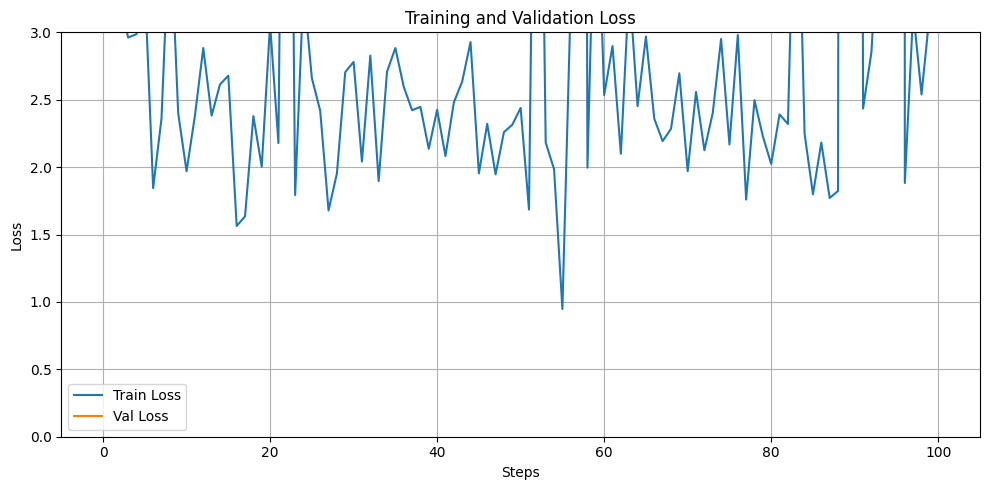

Step 101/1000, Loss: 2.9044
Step 102/1000, Loss: 3.1285
Step 103/1000, Loss: 2.4170
Step 104/1000, Loss: 2.4910
Step 105/1000, Loss: 2.8710
Step 106/1000, Loss: 3.1304
Step 107/1000, Loss: 2.6397
Step 108/1000, Loss: 2.3114
Step 109/1000, Loss: 2.4866
Step 110/1000, Loss: 2.7839
Step 111/1000, Loss: 2.3212
Step 112/1000, Loss: 2.0915
Step 113/1000, Loss: 35.9083
Step 114/1000, Loss: 2.5053
Step 115/1000, Loss: 2.1414
Step 116/1000, Loss: 2.9648
Step 117/1000, Loss: 153.2257
Step 118/1000, Loss: 122.5703
Step 119/1000, Loss: 6.9447
Step 120/1000, Loss: 5.1345
Step 121/1000, Loss: 5.7772
Step 122/1000, Loss: 5.7445
Step 123/1000, Loss: 5.4187
Step 124/1000, Loss: 5.0302
Step 125/1000, Loss: 4.7209
Step 126/1000, Loss: 4.5081
Step 127/1000, Loss: 4.8164
Step 128/1000, Loss: 4.6811
Step 129/1000, Loss: 4.5569
Step 130/1000, Loss: 4.6392
Step 131/1000, Loss: 4.6987
Step 132/1000, Loss: 4.8867
Step 133/1000, Loss: 4.6533
Step 134/1000, Loss: 4.5328
Step 135/1000, Loss: 4.3220
Step 136/1000, 

  0%|          | 0/263 [00:00<?, ?it/s]

[Eval at step 200] Val Loss: 5.5605


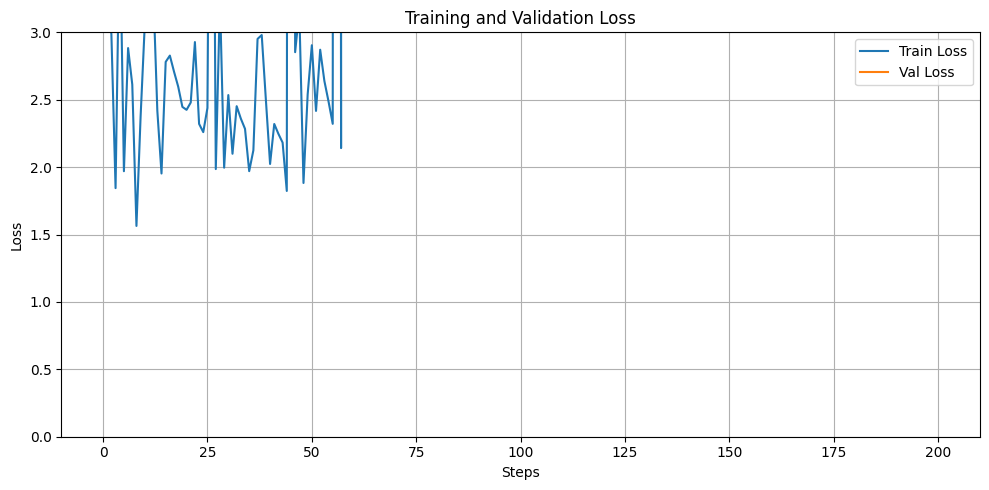

Step 201/1000, Loss: 4.3400
Step 202/1000, Loss: 4.2810
Step 203/1000, Loss: 4.3724
Step 204/1000, Loss: 4.2403
Step 205/1000, Loss: 4.2529
Step 206/1000, Loss: 4.3290
Step 207/1000, Loss: 4.4955
Step 208/1000, Loss: 4.3536
Step 209/1000, Loss: 4.3251
Step 210/1000, Loss: 67.8426
Step 211/1000, Loss: 4.5665
Step 212/1000, Loss: 4.3994
Step 213/1000, Loss: 4.3559
Step 214/1000, Loss: 4.4021
Step 215/1000, Loss: 4.4337
Step 216/1000, Loss: 26.6376
Step 217/1000, Loss: 4.6364
Step 218/1000, Loss: 4.4278
Step 219/1000, Loss: 4.4374
Step 220/1000, Loss: 4.4348
Step 221/1000, Loss: 4.5824
Step 222/1000, Loss: 4.5504
Step 223/1000, Loss: 4.5483
Step 224/1000, Loss: 4.4290
Step 225/1000, Loss: 4.2394
Step 226/1000, Loss: 4.2976
Step 227/1000, Loss: 4.3568
Step 228/1000, Loss: 4.3794
Step 229/1000, Loss: 4.3986
Step 230/1000, Loss: 4.3433
Step 231/1000, Loss: 4.5907
Step 232/1000, Loss: 45.9385
Step 233/1000, Loss: 4.3157
Step 234/1000, Loss: 4.4138
Step 235/1000, Loss: 5.6666
Step 236/1000, Lo

  0%|          | 0/263 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm


model.config.use_cache = False
model.config.pretraining_tp = 1
gradient_accumulation_steps = 4
max_steps=1000
max_loss = 1e9

# Track losses
train_losses = []
running_train_loss=[]
val_losses = []
steps = []
val_steps=[]

# Define optimizer
params_to_optimize = list(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = Adam8bit(params_to_optimize, lr=1e-4)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_steps,
)
# Training loop
model.train()

global_step= 0

while global_step< max_steps:
    for step,batch in enumerate(train_dataloader):
        model.config.use_cache = False
        model.train()
        
        # Forward pass
        outputs = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'), labels=batch['labels'].to('cuda'))
        loss = outputs.loss
        running_train_loss.append(loss.item())
        # loss = loss / gradient_accumulation_steps  # Normalize loss
        loss.backward()
        
        # if (step + 1) % gradient_accumulation_steps == 0:
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        global_step += 1
        if global_step >= max_steps:
            break
        
        print(f"Step {global_step}/{max_steps}, Loss: {loss.item():.4f}")

        if global_step % 100 == 0:
            flush()
            # Store train loss
            train_losses.append(np.mean(running_train_loss[-20:]))
            steps.append(global_step)

            # Evaluate on validation set
            model.eval()
            total_val_loss = 0
            count = 0
            with torch.no_grad():
                pbar = tqdm(test_dataloader, total=len(test_dataloader), leave=True)
                for val_batch in pbar:
                    val_outputs = model(
                        input_ids=val_batch['input_ids'].to('cuda'),
                        attention_mask=val_batch['attention_mask'].to('cuda'),
                        labels=val_batch['labels'].to('cuda')
                    )
                    total_val_loss += val_outputs.loss.item()
                    count += 1
                    pbar.set_postfix({'val_loss': f'{(total_val_loss / count):.4f}'})
            avg_val_loss = total_val_loss / count
            val_losses.append(avg_val_loss)
            val_steps.append(global_step)
            print(f"[Eval at step {global_step}] Val Loss: {avg_val_loss:.4f}")
            model.train()
            # Plotting losses
            plt.figure(figsize=(10, 5))
            plt.plot(running_train_loss[::len(val_steps)], label='Train Loss')
            plt.plot(val_steps, val_losses, label='Val Loss')
            plt.ylim([0,3])
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig("train_val_loss_plot.png")
            plt.show()
            
        # if global_step % 20 == 0:
        #     pred = generate_eval(model=model,idx=40,disable_lora=False)
        #     print('*'*20,step+1,'*'*20)
        #     print("Predictions:", pred)
        #     print('*'*20,'end','*'*20)
            
        # if loss.item() < max_loss:
        #     model.save_pretrained('/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')
        #     max_loss = loss.item()
                
         
flush()

In [23]:
pred = generate_eval(model=model,idx=40,disable_lora=False)
print('*'*20,step+1,'*'*20)
print("Predictions:", pred)
print('*'*20,'end','*'*20)

Attempting to cast a BatchEncoding to type torch.float16. This is not supported.


******************** 300 ********************
Predictions: <bos><bos><start_of_turn>user
‡¨≠‡≠Å‡¨¨‡¨®‡≠á‡¨∂‡≠ç‡≠±‡¨∞‡¨∞ ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞‡¨∞ ‡¨á‡¨§‡¨ø‡¨π‡¨æ‡¨∏ ‡¨ï‚Äô‡¨£?<end_of_turn>
<start_of_turn>model
‡¨ï‡≠ã‡¨∞‡¨ø‡¨Æ‡≠ü‡¨ï ‡¨™‡≠ç‡¨∞‡≠ç‡¨∞ ‡¨Ü, ‡¨™‡¨∞‡¨ö‡¨™‡≠ã‡¨ï‡¨∑‡¨®‡≠ç ‡¨®‡¨§‡¨ö‡¨∞‡¨æ ‡¨™‡≠ç‡¨∞‡≠á‡¨≤‡≠ã‡¨Æ<end_of_turn>
******************** end ********************


# Loading the LoRA and saving the Adapter

In [ ]:
# model_with_adapter.save_pretrained('/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')

In [7]:
# Load the adapter into the base model
model = PeftModel.from_pretrained(model, '/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj):

In [10]:
pred = generate_eval(model,idx=40,disable_lora=False)
print(pred)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|begin_of_text|> <|start_header_id|>user<|end_header_id|>

‡¨≠‡≠Å‡¨¨‡¨®‡≠á‡¨∂‡≠ç‡≠±‡¨∞‡¨∞ ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨Æ‡¨®‡≠ç‡¨¶‡¨ø‡¨∞‡¨∞ ‡¨á‡¨§‡¨ø‡¨π‡¨æ‡¨∏ ‡¨ï‚Äô‡¨£?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

‡¨™‡≠Ç‡¨∞‡≠ç‡¨¨-‡¨ó‡≠ã‡¨ü‡¨ø‡¨è ‡¨ñ‡≠à‡¨≥‡¨ß‡¨ô‡≠ç‡¨ö, ‡¨Ø‡≠á‡¨â‡¨Å‡¨†‡¨ø ‡¨Ö‡¨Ç‡¨ò‡¨æ‡¨°‡¨º‡¨ø ‡¨∏‡≠É‡¨∑‡≠ç‡¨ü‡¨ø ‡¨•‡¨ø‡¨≤‡¨æ‡•§ ‡¨Ü‡¨û‡≠ç‡¨ö‡¨≥‡¨ø‡¨ï ‡¨∏‡≠å‡¨®‡≠ç‡¨¶‡¨∞‡≠ç‡¨Ø‡≠ç‡≠ü ‡¨∏‡¨´‡¨∞ ‡¨ï‡¨∞‡¨ø‡¨õ‡¨ø, ‡¨ì ‡¨∏‡≠ç‡¨•‡¨æ‡¨®‡≠Ä‡≠ü ‡¨î‡¨™‡¨®‡¨ø‡¨¨‡≠á‡¨∂‡¨ï‡¨Æ‡¨æ‡¨®‡≠á ‡¨™‡≠ç‡¨∞‡¨µ‡≠á‡¨∂ ‡¨ï‡¨∞‡≠Å‡¨õ‡¨®‡≠ç‡¨§‡¨ø‡•§
" " - ‡¨¢. ‡¨™‡≠ç‡¨∞‡≠ã‡¨´‡≠á‡¨∏‡¨∞ ‡¨ê. ‡¨∞‡≠á‡¨®‡¨ø (1928) | ‡¨è‡¨π‡¨æ ‡¨§‡≠ç‡¨∞‡≠ü‡≠ã‡¨¶‡¨∂ ‡¨∂‡¨§‡¨æ‡¨¨‡≠ç‡¨¶‡≠Ä‡¨∞‡≠á ‡¨∏‡¨Æ‡≠ç‡¨™‡¨∞‡≠ç‡¨ï‡¨ø‡¨§ ‡¨è‡¨ï ‡¨ú‡¨æ‡¨∞‡¨ø‡¨¨‡¨æ‡¨∞ ‡¨™‡¨æ‡¨≥‡¨® ‡¨ï‡¨∞‡≠Å‡¨õ‡¨ø ‡•§ ‡¨∞‡¨æ‡¨ú‡¨æ‡¨∞‡¨æ‡¨£‡≠Ä ‡¨¶‡≠Å


In [ ]:
# Path to your saved checkpoint
save_path = "/home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt"

# Load checkpoint
checkpoint = torch.load(save_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

# Restore model, optimizer, scheduler, and step
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
global_step = checkpoint['global_step']

# print(f"Checkpoint loaded from {save_path} at step {global_step}")

In [ ]:
checkpoint

In [ ]:
global_step = checkpoint['global_step']

In [ ]:
global_step

: 

In [ ]:
save_path = "/home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'global_step': global_step
}, save_path)

print(f"Checkpoint saved to {save_path}")